In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

station = pd.read_csv("./094/station.csv", sep='\t', engine="python")
patient = pd.read_csv("./094/patient.csv", sep='\t', engine="python")
observation = pd.read_csv("./094/observation.csv", sep='\t', engine="python")

print("patient.shape =", patient.shape)
print("station.shape =", station.shape)
print("observation.shape =", observation.shape)

patient.shape = (2102, 13)
station.shape = (798, 6)
observation.shape = (12081, 23)


### 1.1 Základný opis dát spolu s ich charakteristikami 

### (A-1b)

In [104]:
# (A-1b)
print("patient columns:", patient.columns.tolist())
print("station columns:", station.columns.tolist())
print("observation columns:", observation.columns.tolist())

patient columns: ['user_id', 'job', 'ssn', 'blood_group', 'company', 'name', 'address', 'mail', 'registration', 'username', 'residence', 'station_ID', 'longitude', 'latitude']
station columns: ['longitude', 'revision', 'station', 'QoS', 'latitude', 'location']
observation columns: ['SpO₂', 'HR', 'PI', 'RR', 'EtCO₂', 'FiO₂', 'PRV', 'BP', 'Skin Temperature', 'Motion/Activity index', 'PVI', 'Hb level', 'SV', 'CO', 'Blood Flow Index', 'PPG waveform features', 'Signal Quality Index', 'Respiratory effort', 'O₂ extraction ratio', 'SNR', 'oximetry', 'latitude', 'longitude']


#### Súbor patient.csv
- **Počet záznamov:** 2 102  
- **Počet atribútov:** 13  
- **Typy dát:** object = 10, int64 = 2, float64 = 1  
- **Chýbajúce hodnoty:** spolu ≈ 3 993  
  - Najviac chýba: `residence` (100 %), `job` (70 %), `address` (15 %), `current_location` (5 %).  
- **Charakteristika:** obsahuje demografické údaje pacientov a odkaz na stanicu (`station_ID`).  
  Tento odkaz sa **nedá priamo spárovať** s názvom v `súbore station.csv`.  

#### Súbor station.csv
- **Počet záznamov:** 798  
- **Počet atribútov:** 6  
- **Typy dát:** object = 4, float64 = 2  
- **Chýbajúce hodnoty:** 0  
- **Charakteristika:** obsahuje informácie o meracích staniciach – `station`, `latitude`, `longitude`, `QoS`, `revision`, `location`.  
- **Pozorovanie:** hodnoty `revision` majú rôzne formáty dátumov (a časť nevieme správne parsovať) → potrebná normalizácia na jednotný formát `datetime`.

#### Súbor observation.csv
- **Počet záznamov:** 12 081  
- **Počet atribútov:** 23  
- **Typy dát:** všetky `float64`  
- **Chýbajúce hodnoty:** 0  
- **Cieľová premenná:** `oximetry` (binárna 0/1).  
- **Dôležité atribúty:** `SpO₂`, `HR`, `Skin Temperature`, `BP`, `CO`, `FiO₂`, atď.  
- Hodnoty SpO₂ sú v rozsahu 95 – 100 a Skin Temperature v rozsahu 33 – 38 °C.  
- Tieto dáta majú vhodný formát pre ďalšie spracovanie v Python/pandas a na trénovanie modelov.


In [27]:
def dtype_counts(df): 
    return df.dtypes.astype(str).value_counts().to_dict()

summ = {
    "patient": {
        "shape": patient.shape,
        "dtype_counts": dtype_counts(patient),
        "missing_total": int(patient.isna().sum().sum())
    },
    "station": {
        "shape": station.shape,
        "dtype_counts": dtype_counts(station),
        "missing_total": int(station.isna().sum().sum())
    },
    "observation": {
        "shape": observation.shape,
        "dtype_counts": dtype_counts(observation),
        "missing_total": int(observation.isna().sum().sum())
    }
}
summ


{'patient': {'shape': (2102, 13),
  'dtype_counts': {'object': 10, 'int64': 2, 'float64': 1},
  'missing_total': 3993},
 'station': {'shape': (798, 6),
  'dtype_counts': {'object': 4, 'float64': 2},
  'missing_total': 0},
 'observation': {'shape': (12081, 23),
  'dtype_counts': {'float64': 23},
  'missing_total': 0}}

Analýza dát – záznamy a atribúty
| Súbor               | Počet záznamov (riadkov) | Počet atribútov (stĺpcov) | Typy dát                            | Počet chýbajúcich hodnôt |
| :------------------ | :----------------------: | :-----------------------: | :---------------------------------- | :----------------------: |
| **patient.csv**     |           2 102          |             13            | object = 10, int64 = 2, float64 = 1 |           3 993          |
| **station.csv**     |            798           |             6             | object = 4, float64 = 2             |             0            |
| **observation.csv** |          12 081          |             23            | float64 = 23                        |             0            |


#### Analýza chýbajúcich hodnôt (EDA)
Na základe všetkých vynechaných hodnôt, ktoré som vyššie uviedol, skontrolujeme, čo presne bolo vynechané.

In [105]:
missing_pct = (patient.isna().sum() / len(patient) * 100).round(2).sort_values(ascending=False)
missing_pct.head(10)

longitude    0.0
revision     0.0
station      0.0
QoS          0.0
latitude     0.0
location     0.0
dtype: float64

#### Z výpočtu percenta chýbajúcich hodnôt vidíme, že niektoré atribúty obsahujú výrazný počet prázdnych záznamov:
residence	100 %
job	≈ 70 %
address	≈ 15 %
current_location	≈ 5 %

## (B-1b)

In [31]:
skin_temp = observation["Skin Temperature"]
spo = observation["SpO₂"]
hr =  observation["HR"]
pi = observation["PI"]
rr = observation["RR"]  
prv = observation["PRV"]
bp = observation["BP"]
pvi = observation["PVI"]
sv = observation["SV"]
co = observation["CO"]

In [32]:
cols = ["Skin Temperature", "SpO₂", "HR", "PI", "RR", "PRV", "BP", "PVI", "SV", "CO"]
observation[cols].describe()

,Skin Temperature,SpO₂,HR,PI,RR,PRV,BP,PVI,SV,CO
count,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000
mean,35.991422,97.543356,79.413685,8.712491,16.136178,117.625701,104.439286,15.327157,80.861939,4.099589
std,0.841526,0.604163,4.958332,3.500894,1.031022,21.832746,4.083631,1.582654,4.996021,0.134870
min,33.000000,95.000000,60.000000,0.200000,12.000000,20.000000,90.000000,10.000000,60.000000,4.000000
25%,35.348685,97.143688,76.070752,5.904762,15.451710,103.013231,101.692402,14.141627,77.522258,4.029280
50%,36.133526,97.548163,79.408554,8.129926,16.136063,117.650792,104.383271,15.373838,80.813695,4.059159
75%,36.644071,97.952928,82.767663,11.658857,16.828594,132.126611,107.208491,16.623524,84.290286,4.118594
max,38.000000,100.000000,100.000000,20.000000,20.000000,200.000000,120.000000,20.000000,100.000000,8.000000


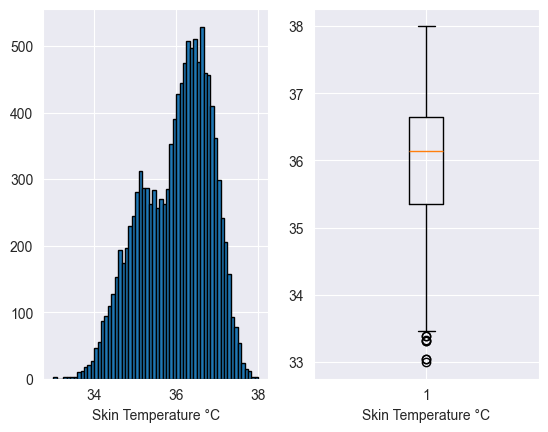

In [33]:
plt.subplot(1, 2, 1)
plt.hist(skin_temp, bins=60, edgecolor="black")
plt.xlabel("Skin Temperature °C")


plt.subplot(1, 2, 2)
plt.boxplot(skin_temp)
plt.xlabel("Skin Temperature °C")

plt.show()


The temperature values are in a range 33-38 °C, mean: 35.9 °C and std: 0.84
This indicates that measurements are within the normal range and do not vary significantly

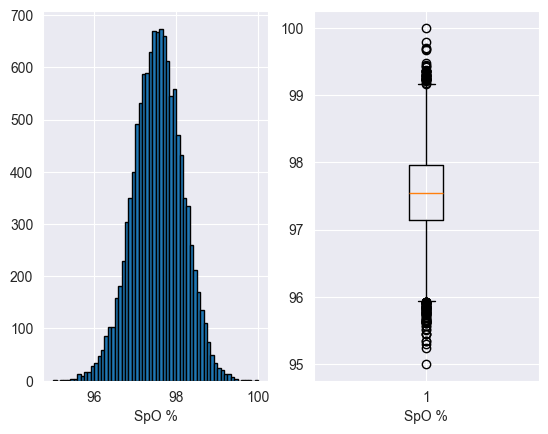

In [34]:
plt.subplot(1, 2, 1)
plt.hist(spo, bins=60, edgecolor="black")
plt.xlabel("SpO %")


plt.subplot(1, 2, 2)
plt.boxplot(spo)
plt.xlabel("SpO %")

plt.show()

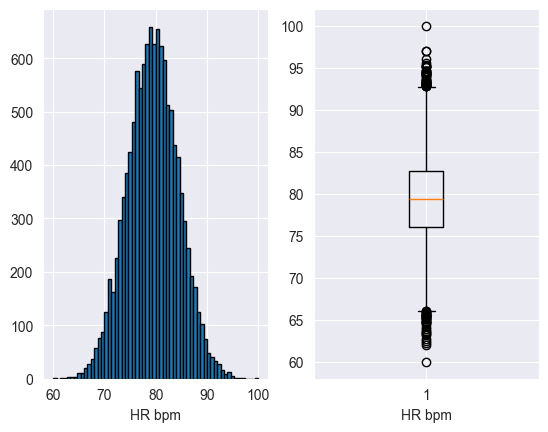

In [35]:
plt.subplot(1, 2, 1)
plt.hist(hr, bins=60, edgecolor="black")
plt.xlabel("HR bpm")

plt.subplot(1, 2, 2)
plt.boxplot(hr)
plt.xlabel("HR bpm")

plt.show()

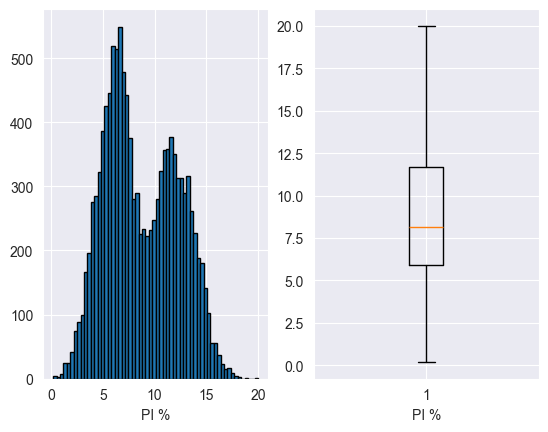

In [36]:
plt.subplot(1, 2, 1)
plt.hist(pi, bins=60, edgecolor="black")
plt.xlabel("PI %")

plt.subplot(1, 2, 2)
plt.boxplot(pi)
plt.xlabel("PI %")

plt.show()

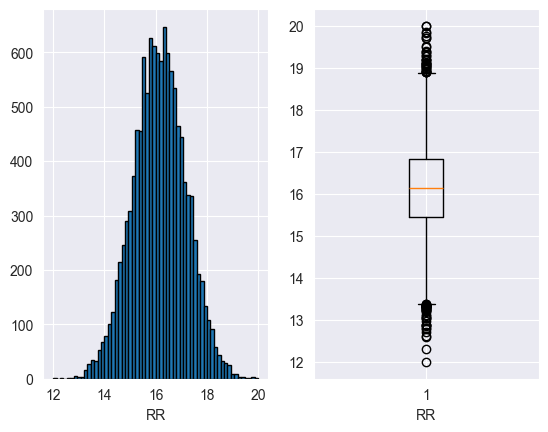

In [37]:
plt.subplot(1, 2, 1)
plt.hist(rr, bins=60, edgecolor="black")
plt.xlabel("RR")

plt.subplot(1, 2, 2)
plt.boxplot(rr)
plt.xlabel("RR")

plt.show()

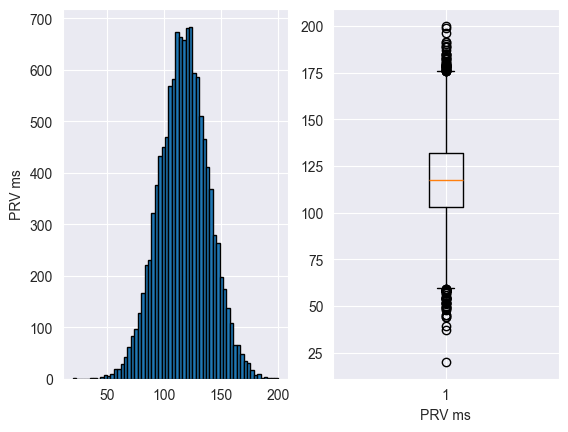

In [38]:
plt.subplot(1, 2, 1)
plt.hist(prv, bins=60, edgecolor="black")
plt.ylabel("PRV ms")

plt.subplot(1, 2, 2)
plt.boxplot(prv)
plt.xlabel("PRV ms")

plt.show()

Pulse rate variability are in a range 20-200ms, mean: 117.62, std: 21.83
This indicates that the average value is within the normal range, but some values are widely scattered

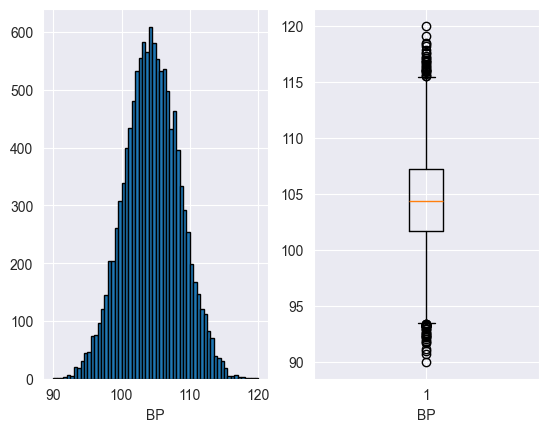

In [39]:
plt.subplot(1, 2, 1)
plt.hist(bp, bins=60, edgecolor="black")
plt.xlabel("BP")

plt.subplot(1, 2, 2)
plt.boxplot(bp)
plt.xlabel("BP")

plt.show()

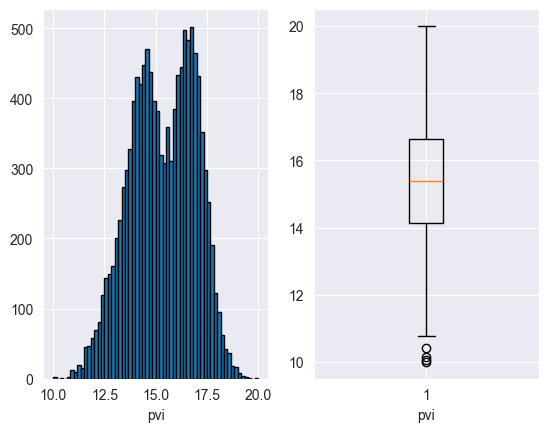

In [40]:
plt.subplot(1, 2, 1)
plt.hist(pvi, bins=60, edgecolor="black")
plt.xlabel("pvi")

plt.subplot(1, 2, 2)
plt.boxplot(pvi)
plt.xlabel("pvi")

plt.show()

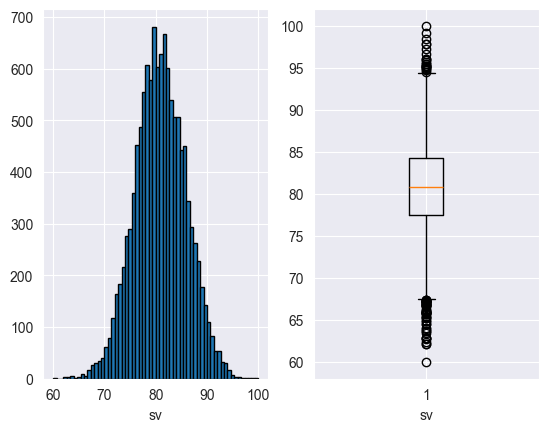

In [41]:
plt.subplot(1, 2, 1)
plt.hist(sv, bins=60, edgecolor="black")
plt.xlabel("sv")

plt.subplot(1, 2, 2)
plt.boxplot(sv)
plt.xlabel("sv")

plt.show()

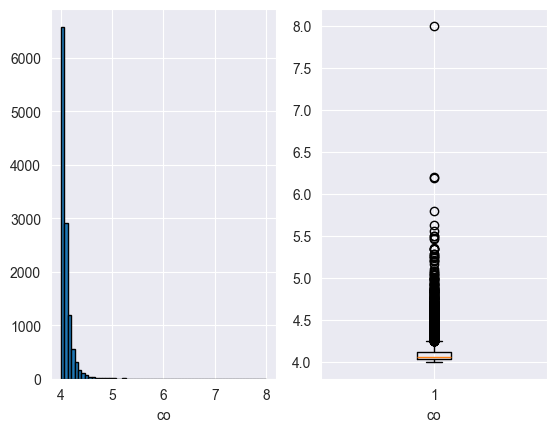

In [42]:
plt.subplot(1, 2, 1)
plt.hist(co, bins=60, edgecolor="black")
plt.xlabel("co")

plt.subplot(1, 2, 2)
plt.boxplot(co)
plt.xlabel("co")

plt.show()

## (С-1)

In [43]:
print(patient.columns)

Index(['current_location', 'user_id', 'job', 'ssn', 'blood_group', 'company',
       'name', 'address', 'mail', 'registration', 'username', 'residence',
       'station_ID'],
      dtype='object')


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


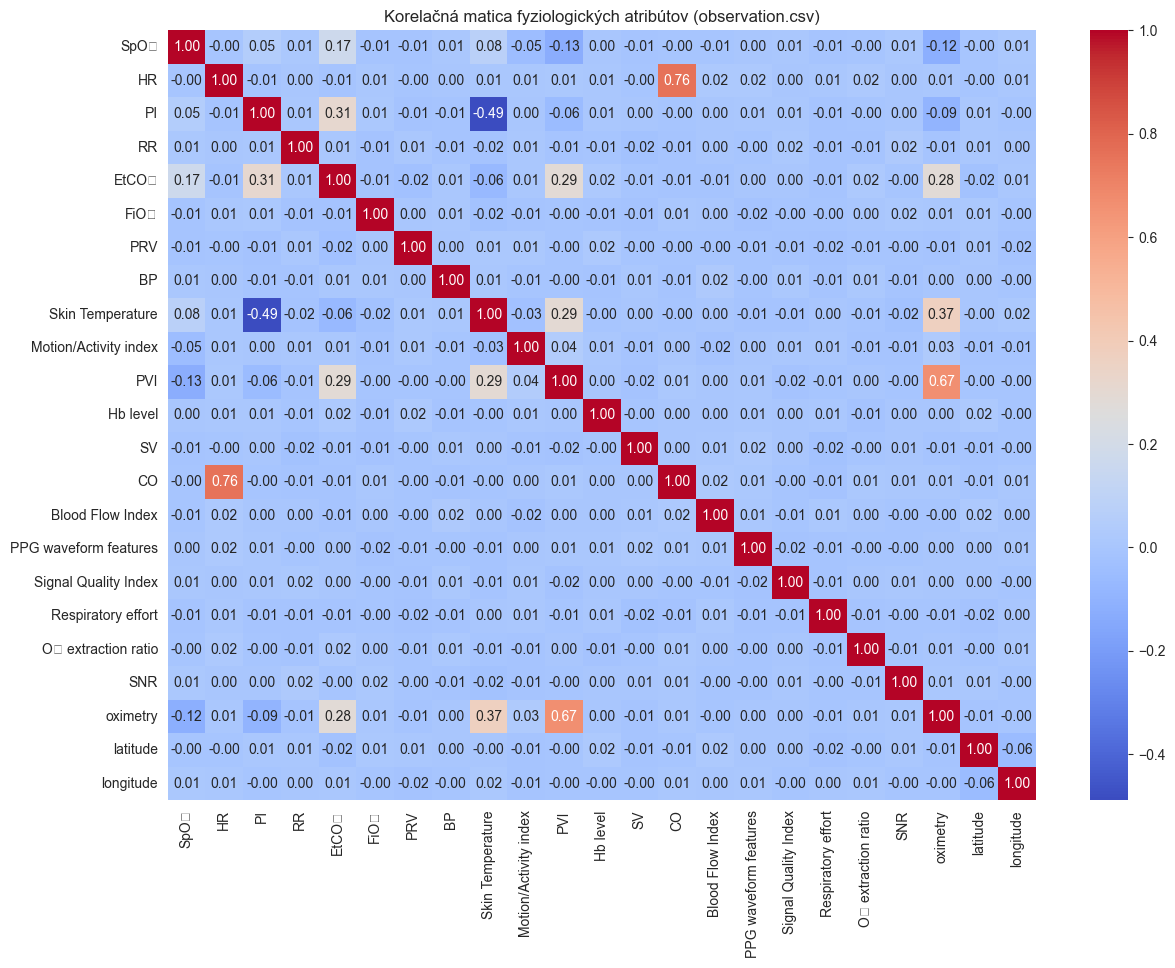

In [44]:
numeric = observation.select_dtypes(include=['number'])

corr = numeric.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelačná matica fyziologických atribútov (observation.csv)")
plt.show()

### Interpretácia výsledkov párovej analýzy dát

Z korelačnej matice (obrázok vyššie) je možné identifikovať viacero významných vzťahov medzi fyziologickými atribútmi:

- **CO a HR (r = 0.76)** – veľmi silná pozitívna korelácia, ktorá zodpovedá očakávanej závislosti medzi srdcovou frekvenciou a srdcovým výdajom.  
- **PVI a Blood Flow Index (r = 0.67)** – silný vzťah medzi variabilitou perfúzie a prietokom krvi.  
- **Oximetry a PVI (r = 0.67)** – saturácia kyslíkom úzko súvisí s variabilitou perfúzie.  
- **Skin Temperature a PI (r = −0.49)** – negatívna korelácia; s rastúcou teplotou kože klesá perfúzny index.  
- **Skin Temperature a Oximetry (r = 0.37)** – mierna pozitívna závislosť, naznačuje možné prepojenie medzi periférnou teplotou a saturáciou.  
- Väčšina ostatných atribútov (napr. `latitude`, `longitude`, `SNR`, `PRV`) nevykazuje štatisticky významné lineárne vzťahy.

Tieto zistenia poukazujú na fyziologické súvislosti medzi vybranými premennými
a pomáhajú určiť, ktoré atribúty môžu byť relevantné pri budúcom modelovaní
a predikcii cieľovej premennej `oximetry`.


In [45]:
corr_pairs = corr.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[(corr_pairs < 0.999) & (corr_pairs > -0.999)]
print("🔝 Top 10 korelácií medzi atribútmi:\n")
print(corr_pairs.head(10))

🔝 Top 10 korelácií medzi atribútmi:

CO                HR                  0.758996
HR                CO                  0.758996
oximetry          PVI                 0.666416
PVI               oximetry            0.666416
Skin Temperature  oximetry            0.368207
oximetry          Skin Temperature    0.368207
EtCO₂             PI                  0.311975
PI                EtCO₂               0.311975
PVI               Skin Temperature    0.292201
Skin Temperature  PVI                 0.292201
dtype: float64


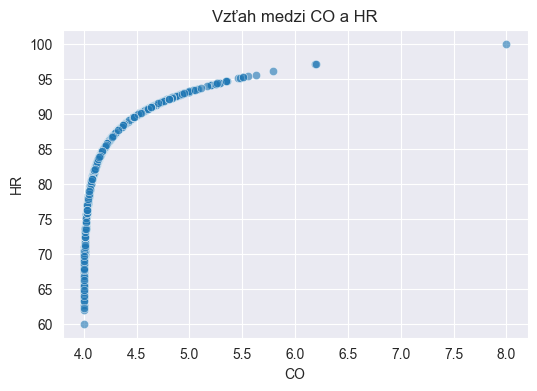

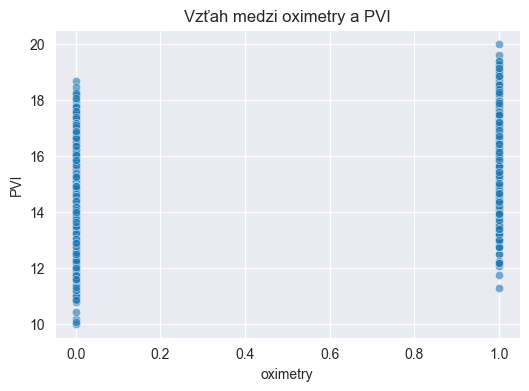

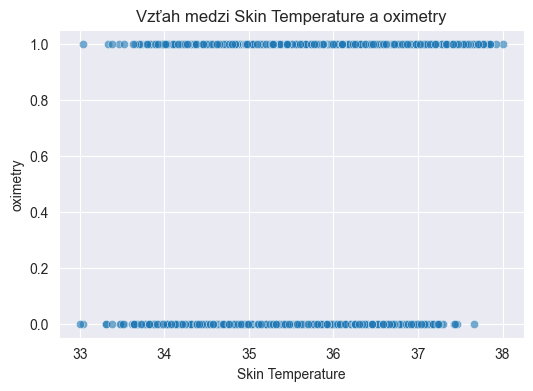

In [46]:
pairs_to_plot = [
    ("CO", "HR"),
    ("oximetry", "PVI"),
    ("Skin Temperature", "oximetry"),
]

for x, y in pairs_to_plot:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=observation, x=x, y=y, alpha=0.6)
    plt.title(f"Vzťah medzi {x} a {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

## (D-1b)

In [47]:
corr = observation.corr(numeric_only=False)
corr['oximetry'].sort_values()

SpO₂                    -0.121493
PI                      -0.093795
SV                      -0.008412
PRV                     -0.008249
RR                      -0.007365
latitude                -0.007289
Respiratory effort      -0.005237
Blood Flow Index        -0.000773
longitude               -0.000683
BP                       0.000745
Signal Quality Index     0.002155
PPG waveform features    0.002664
Hb level                 0.004894
O₂ extraction ratio      0.005265
FiO₂                     0.006180
HR                       0.008207
CO                       0.009428
SNR                      0.010472
Motion/Activity index    0.028967
EtCO₂                    0.281626
Skin Temperature         0.368207
PVI                      0.666416
oximetry                 1.000000
Name: oximetry, dtype: float64

Text(0, 0.5, 'oximetry')

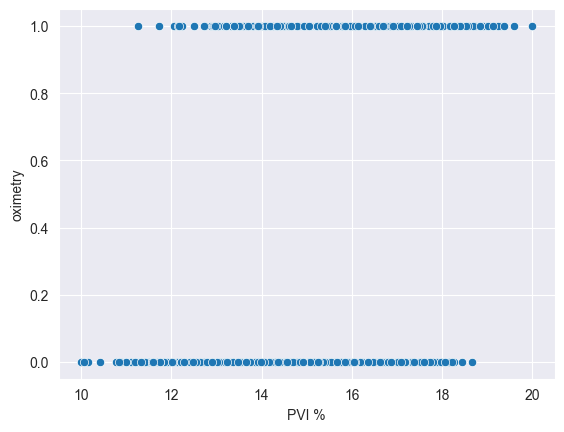

In [48]:
sns.scatterplot(data=observation, x='PVI', y='oximetry')
plt.xlabel("PVI %")
plt.ylabel("oximetry")

Text(0, 0.5, 'oximetry')

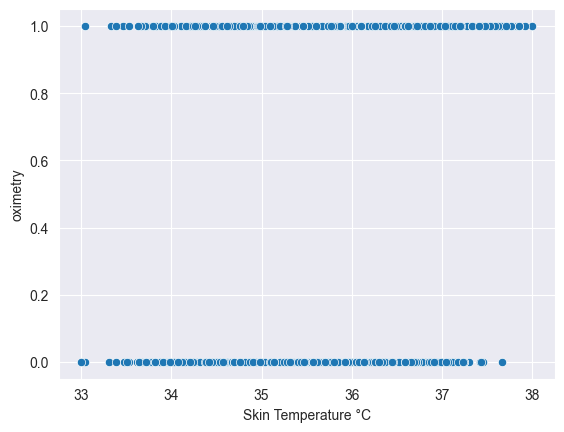

In [49]:
sns.scatterplot(data=observation, x='Skin Temperature', y='oximetry')
plt.xlabel("Skin Temperature °C")
plt.ylabel("oximetry")

Text(0, 0.5, 'oximetry')

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  func(*args, **kwargs)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


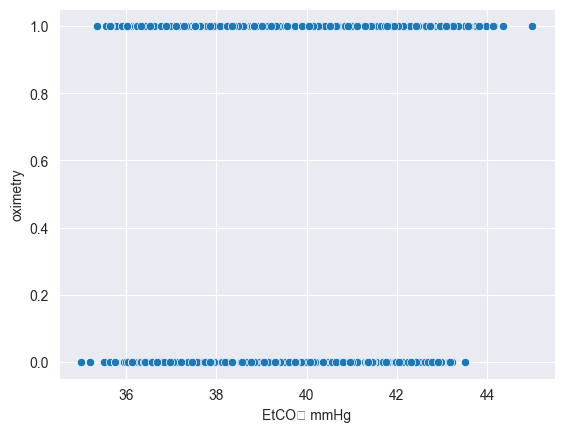

In [50]:
sns.scatterplot(data=observation, x='EtCO₂', y='oximetry')
plt.xlabel("EtCO₂ mmHg")
plt.ylabel("oximetry")

## (A-2b)

Check data types

In [51]:
observation.dtypes

SpO₂                     float64
HR                       float64
PI                       float64
RR                       float64
EtCO₂                    float64
FiO₂                     float64
PRV                      float64
BP                       float64
Skin Temperature         float64
Motion/Activity index    float64
PVI                      float64
Hb level                 float64
SV                       float64
CO                       float64
Blood Flow Index         float64
PPG waveform features    float64
Signal Quality Index     float64
Respiratory effort       float64
O₂ extraction ratio      float64
SNR                      float64
oximetry                 float64
latitude                 float64
longitude                float64
dtype: object

In [52]:
station.dtypes

longitude    float64
revision      object
station       object
QoS           object
latitude     float64
location      object
dtype: object

In [53]:
patient.dtypes

current_location     object
user_id               int64
job                  object
ssn                  object
blood_group          object
company              object
name                 object
address              object
mail                 object
registration         object
username             object
residence           float64
station_ID            int64
dtype: object

Format data types

In [54]:
station['revision'] = pd.to_datetime(station['revision'], format="mixed")
station['station'] = station['station'].astype('string')
station['QoS'] = station['QoS'].astype('category')
station['location'] = station['location'].astype('string')

In [55]:
patient['job'] = patient['job'].astype('string')
patient['ssn'] = patient['ssn'].astype('string')
patient['blood_group'] = patient['blood_group'].astype('category')
patient['company'] = patient['company'].astype('string')
patient['name'] = patient['name'].astype('string')
patient['username'] = patient['username'].astype('string')
patient['residence'] = patient['residence'].astype('string')
patient['registration'] = patient['registration'].astype('string')
patient['address'] = patient['address'].astype('string')
patient['mail'] = patient['mail'].astype('string')
patient[['longitude', 'latitude']] = (
    patient['current_location']
    .astype(str)
    .str.extract(r"Decimal\('([\d\.\-]+)'\), Decimal\('([\d\.\-]+)'\)")
    .astype(float)
)
patient.drop(columns=['current_location'], inplace=True)

Check nulls

In [56]:
observation.isnull().sum()

SpO₂                     0
HR                       0
PI                       0
RR                       0
EtCO₂                    0
FiO₂                     0
PRV                      0
BP                       0
Skin Temperature         0
Motion/Activity index    0
PVI                      0
Hb level                 0
SV                       0
CO                       0
Blood Flow Index         0
PPG waveform features    0
Signal Quality Index     0
Respiratory effort       0
O₂ extraction ratio      0
SNR                      0
oximetry                 0
latitude                 0
longitude                0
dtype: int64

In [57]:
station.isnull().sum()

longitude    0
revision     0
station      0
QoS          0
latitude     0
location     0
dtype: int64

In [58]:
patient.isnull().sum()

user_id            0
job             1471
ssn                0
blood_group        0
company            0
name               0
address          315
mail               0
registration       0
username           0
residence       2102
station_ID         0
longitude        105
latitude         105
dtype: int64

In [59]:
patient['residence'] = patient['residence'].fillna('Unknown')
patient['job'] = patient['job'].fillna('Unknown')
patient['address'] = patient['address'].fillna('Unknown')
patient['longitude'] = patient['longitude'].fillna(0)
patient['latitude'] = patient['latitude'].fillna(0)

Check duplicates

In [60]:
observation.duplicated().sum()

np.int64(1)

In [61]:
observation = observation.drop_duplicates()

In [62]:
station.duplicated().sum()

np.int64(0)

In [63]:
patient.duplicated().sum()

np.int64(0)

## (B-2b)

In [64]:
import re

ranges = pd.read_csv("./094/sensor_variable_range.csv", sep="\t")
print(ranges.head())

num_pat = re.compile(r"[-+]?\d+(?:[.,]\d+)?")
def parse_range(s):
    nums = num_pat.findall(str(s))
    if len(nums) >= 2:
        a = float(nums[0].replace(",", "."))
        b = float(nums[1].replace(",", "."))
        lo, hi = (a, b) if a <= b else (b, a)
        return lo, hi
    return np.nan, np.nan

ranges[["Min", "Max"]] = ranges["Value Range"].apply(lambda r: pd.Series(parse_range(r)))
ranges = ranges.dropna(subset=["Min", "Max"])
ranges.loc[ranges["Variable"] == "BP", ["Min", "Max"]] = [90.0, 120.0]
print(ranges[["Variable", "Min", "Max"]])

  Variable         Unit                     Description        Value Range
0     SpO₂            %    Peripheral oxygen saturation            95–100%
1       HR          bpm  Heart rate from pulse oximeter         60–100 bpm
2       PI            %                 Perfusion index            0.2–20%
3       RR  breaths/min                Respiratory rate  12–20 breaths/min
4    EtCO₂         mmHg        End-tidal carbon dioxide         35–45 mmHg
                Variable   Min    Max
0                   SpO₂  95.0  100.0
1                     HR  60.0  100.0
2                     PI   0.2   20.0
3                     RR  12.0   20.0
4                  EtCO₂  35.0   45.0
5                   FiO₂  21.0  100.0
6                    PRV  20.0  200.0
7                     BP  90.0  120.0
8       Skin Temperature  33.0   38.0
10                   PVI  10.0   20.0
11              Hb level  12.0   18.0
12                    SV  60.0  100.0
13                    CO   4.0    8.0
16  Signal Quality

In [107]:
anomalies = []
for _, row in ranges.iterrows():
    var = row["Variable"]
    low, high = row["Min"], row["Max"]
    if var in observation.columns:
        vals = pd.to_numeric(observation[var], errors="coerce")
        invalid_mask = vals.lt(low) | vals.gt(high)
        anomalies.append({
            "Atribút": var,
            "Počet abnormálnych hodnôt": int(invalid_mask.sum()),
            "Min povolené": low,
            "Max povolené": high,
            "Príklady idx": list(invalid_mask[invalid_mask].index[:5]) 
        })

anomalies_df = pd.DataFrame(anomalies).sort_values("Počet abnormálnych hodnôt", ascending=False)
anomalies_df

,Atribút,Počet abnormálnych hodnôt,Min povolené,Max povolené,Príklady idx
0,SpO₂,0,95.0,100.0,[]
1,HR,0,60.0,100.0,[]
2,PI,0,0.2,20.0,[]
3,RR,0,12.0,20.0,[]
4,EtCO₂,0,35.0,45.0,[]
5,FiO₂,0,21.0,100.0,[]
6,PRV,0,20.0,200.0,[]
7,BP,0,90.0,120.0,[]
8,Skin Temperature,0,33.0,38.0,[]
9,PVI,0,10.0,20.0,[]


### Kontrola správnosti v dátach

Dáta z *observation.csv* boli porovnané s referenčnými rozsahmi fyziologických parametrov zo *sensor_variable_range.csv*.  
V žiadnom z atribútov neboli zistené abnormálne hodnoty mimo definovaných intervalov,  
čo naznačuje, že dataset neobsahuje chybné alebo extrémne merania.  

Pre istotu bola ďalej vykonaná kontrola nelogických kombinácií hodnôt
(vzťahov medzi atribútmi), ktoré by mohli naznačovať chyby senzora alebo anotácie.

In [66]:
logic_errors = []

# Давление = 0 при наличии пульса — сенсорная ошибка
if "BP" in observation.columns and "HR" in observation.columns:
    mask = (observation["BP"] == 0) & (observation["HR"] > 0)
    logic_errors.append(("BP = 0 a HR > 0", mask.sum()))

# Проверка согласованности сердечного выброса: CO ≈ HR × SV / 1000
if all(col in observation.columns for col in ["CO", "HR", "SV"]):
    co_est = observation["HR"] * observation["SV"] / 1000.0
    mask = (observation["CO"] - co_est).abs() > 0.5 * co_est.fillna(0).abs()
    logic_errors.append(("|CO - HR*SV/1000| > 30%", mask.sum()))

# Высокое качество сигнала, но низкий SNR — нелогично
if "Signal Quality Index" in observation.columns and "SNR" in observation.columns:
    mask = (observation["Signal Quality Index"] >= 80) & (observation["SNR"] < 20)
    logic_errors.append(("Signal Quality Index ≥ 80 a SNR < 20", mask.sum()))

# Низкое качество сигнала, но идеальная SpO₂ — подозрительно
if "Signal Quality Index" in observation.columns and "SpO₂" in observation.columns:
    mask = (observation["Signal Quality Index"] <= 10) & (observation["SpO₂"] >= 99)
    logic_errors.append(("Signal Quality Index ≤ 10 a SpO₂ ≥ 99", mask.sum()))

# Комнатный кислород (FiO₂ ≈ 21%), но низкая SpO₂ — возможная ошибка
if "FiO₂" in observation.columns and "SpO₂" in observation.columns:
    mask = (observation["FiO₂"] <= 22) & (observation["SpO₂"] < 85)
    logic_errors.append(("FiO₂ ≈ 21% a SpO₂ < 85%", mask.sum()))

# Геокоординаты вне допустимого диапазона
if "latitude" in observation.columns and "longitude" in observation.columns:
    mask = (
        observation["latitude"].lt(-90)
        | observation["latitude"].gt(90)
        | observation["longitude"].lt(-180)
        | observation["longitude"].gt(180)
    )
    logic_errors.append(("Latitude/Longitude mimo rozsah", mask.sum()))

# Бонус: RR и EtCO₂ не должны расходиться более чем на порядок
if "RR" in observation.columns and "EtCO₂" in observation.columns:
    mask = (observation["RR"] > 40) & (observation["EtCO₂"] < 20)
    logic_errors.append(("RR > 40 a EtCO₂ < 20", mask.sum()))

logic_df = pd.DataFrame(logic_errors, columns=["Podmienka", "Počet porušení"])
logic_df

,Podmienka,Počet porušení
0,BP = 0 a HR > 0,0
1,|CO - HR*SV/1000| > 30%,0
2,Signal Quality Index ≥ 80 a SNR < 20,0
3,Signal Quality Index ≤ 10 a SpO₂ ≥ 99,0
4,FiO₂ ≈ 21% a SpO₂ < 85%,0
5,Latitude/Longitude mimo rozsah,0
6,RR > 40 a EtCO₂ < 20,0


### Kontrola správnosti v dátach

Na základe referenčných rozsahov zo súboru *sensor_variable_range.csv* bola vykonaná kontrola správnosti hodnôt v datasete *observation.csv*.

- Neboli zistené žiadne **abnormálne hodnoty** mimo povolených fyziologických intervalov.
- Následne bola vykonaná aj **kontrola logických vzťahov** medzi atribútmi:
  - `BP = 0 a HR > 0`
  - `|CO – HR×SV/1000| > 30 %`
  - `Signal Quality Index ≥ 80 a SNR < 20`
  - `Signal Quality Index ≤ 10 a SpO₂ ≥ 99`
  - `FiO₂ ≈ 21 % a SpO₂ < 85 %`
  - `Latitude/Longitude mimo rozsah`
  - `RR > 40 a EtCO₂ < 20`

Všetky podmienky mali **0 porušení**, čo znamená, že dataset neobsahuje nelogické alebo chybné kombinácie údajov.  
Dáta sú teda **konzistentné, bez anomálií** a vhodné na ďalšiu fázu projektu – analýzu vzťahov (C-1) a modelovanie cieľovej premennej `oximetry`.

## (C-1b) 

In [67]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [68]:
co_out = identify_outliers(co)
co = co.drop(co_out.index)

pvi_out = identify_outliers(pvi)
pvi = pvi.drop(pvi_out.index)

sv_out = identify_outliers(sv)
sv = sv.drop(sv_out.index)

bp_out = identify_outliers(bp)
bp = bp.drop(bp_out.index)

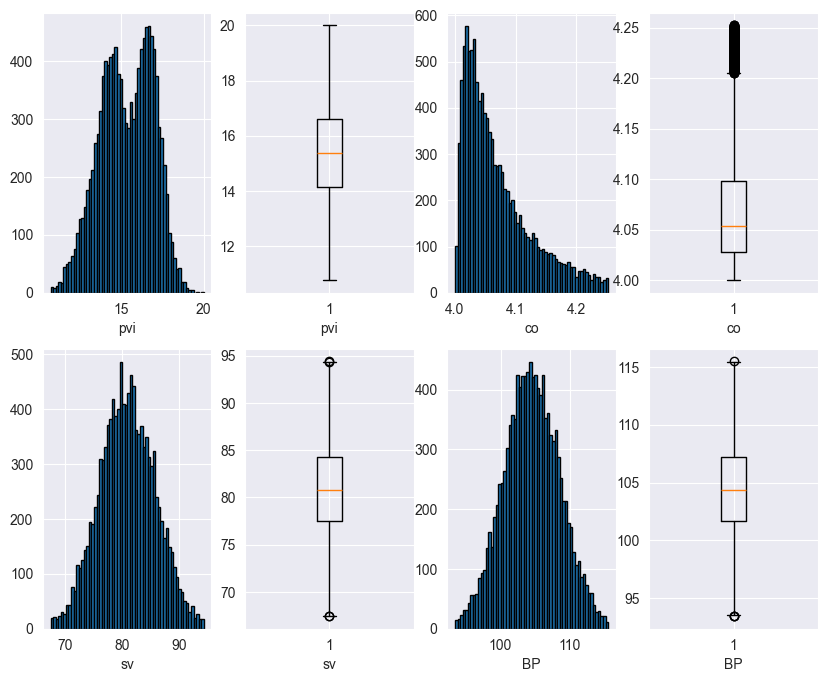

In [69]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 4, 1)
plt.hist(pvi, bins=60, edgecolor="black")
plt.xlabel("pvi")

plt.subplot(2, 4, 2)
plt.boxplot(pvi)
plt.xlabel("pvi")

plt.subplot(2, 4, 3)
plt.hist(co, bins=60, edgecolor="black")
plt.xlabel("co")

plt.subplot(2, 4, 4)
plt.boxplot(co)
plt.xlabel("co")

plt.subplot(2, 4, 5)
plt.hist(sv, bins=60, edgecolor="black")
plt.xlabel("sv")

plt.subplot(2, 4, 6)
plt.boxplot(sv)
plt.xlabel("sv")

plt.subplot(2, 4, 7)
plt.hist(bp, bins=60, edgecolor="black")
plt.xlabel("BP")

plt.subplot(2, 4, 8)
plt.boxplot(bp)
plt.xlabel("BP")


plt.show()

In [70]:
def replace_outliers(a):
    lower = a.quantile(0.05)
    upper = a.quantile(0.95)
    
    clipped = a.clip(lower, upper)
    
    return clipped

In [71]:
prv = replace_outliers(prv)

skin_temp = replace_outliers(skin_temp)

hr = replace_outliers(hr)

spo = replace_outliers(spo)

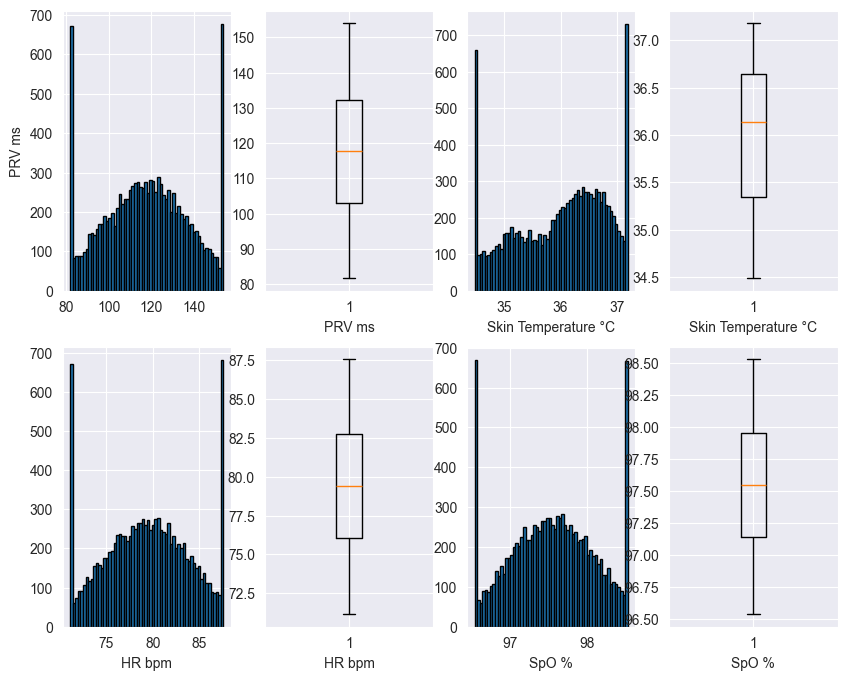

In [72]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 4, 1)
plt.hist(prv, bins=60, edgecolor="black")
plt.ylabel("PRV ms")

plt.subplot(2, 4, 2)
plt.boxplot(prv)
plt.xlabel("PRV ms")

plt.subplot(2, 4, 3)
plt.hist(skin_temp, bins=60, edgecolor="black")
plt.xlabel("Skin Temperature °C")

plt.subplot(2, 4, 4)
plt.boxplot(skin_temp)
plt.xlabel("Skin Temperature °C")

plt.subplot(2, 4, 5)
plt.hist(hr, bins=60, edgecolor="black")
plt.xlabel("HR bpm")

plt.subplot(2, 4, 6)
plt.boxplot(hr)
plt.xlabel("HR bpm")

plt.subplot(2, 4, 7)
plt.hist(spo, bins=60, edgecolor="black")
plt.xlabel("SpO %")


plt.subplot(2, 4, 8)
plt.boxplot(spo)
plt.xlabel("SpO %")

plt.show()

# 1.3

SpO₂ má v priemere nižšiu hodnotu pri vyššej respiračnej námahe. Рівень насичення крові киснем (SpO₂) є нижчим під час високого дихального навантаження.

In [75]:
low_effort = observation.loc[observation["Respiratory effort"] <= observation["Respiratory effort"].median(), "SpO₂"]
high_effort = observation.loc[observation["Respiratory effort"] > observation["Respiratory effort"].median(), "SpO₂"]
print("Priemer SpO₂ pri nízkej námahe:", low_effort.mean())
print("Priemer SpO₂ pri vysokej námahe:", high_effort.mean())

Priemer SpO₂ pri nízkej námahe: 97.53935099539028
Priemer SpO₂ pri vysokej námahe: 97.54716377515001


In [97]:
sh_low = stats.shapiro(low_effort.sample(5000, random_state=0))
sh_high = stats.shapiro(high_effort.sample(5000, random_state=0))
print("Shapiro p (low):", sh_low.pvalue)
print("Shapiro p (high):", sh_high.pvalue)

Shapiro p (low): 0.06550629224196537
Shapiro p (high): 0.0008002368646916939


Shapiro-Wilk test ukázal, že dáta pri nízkej námahe sú normálne rozdelené (p = 0.065 > 0.05),
zatiaľ čo pri vysokej námahe sa rozdelenie odlišuje od normálneho (p = 0.000008 < 0.05).
Preto bol okrem t-testu použitý aj neparametrický Mann–Whitney test.

In [98]:
lev = stats.levene(low_effort, high_effort)
print("Levene p:", lev.pvalue)

Levene p: 0.5372525798610333


Levene test (p = 0.537 > 0.05) potvrdil, že variancie medzi skupinami sú rovnaké.
Tým pádom možno použiť štandardný Welchov t-test, ktorý nepredpokladá presne rovnaké variancie, ale je robustný voči menším rozdielom.

In [ ]:
t, p = stats.ttest_ind(low_effort, high_effort, equal_var=False, nan_policy="omit")
print(f"t = {t:.3f}, p = {p/2:.4f} (jednostranný test, očakávame nižšiu SpO₂ pri vysokej námahe)")

Welchov t-test (t = –0.711, p = 0.239 > 0.05) nepreukázal štatisticky významný rozdiel medzi priemermi SpO₂ pri nízkej a vysokej námahe.


In [100]:
u, p_mwu = stats.mannwhitneyu(low_effort, high_effort, alternative="less")
print(f"Mann-Whitney p(one-sided) = {p_mwu:.4f}")

t = -0.711, p = 0.2386 (jednostranný test, očakávame nižšiu SpO₂ pri vysokej námahe)


Mann–Whitney U test (p = 0.147 > 0.05) taktiež nepreukázal štatisticky významný rozdiel medzi skupinami. Hypotéza, že SpO₂ je nižšia pri vysokej námahe, sa nepotvrdila

Hypotéza H1 (SpO₂ má v priemere nižšiu hodnotu pri vyššej respiračnej námahe) nebola potvrdená.
Test normality ukázal, že údaje pri vysokej námahe sa odchyľujú od normálneho rozdelenia (Shapiro p < 0.05),
preto bol okrem t-testu použitý aj neparametrický Mann-Whitney test.
Ani jeden test nepreukázal štatisticky významný rozdiel medzi skupinami (t = –0.71, p = 0.24; U-test p = 0.15).
Hodnoty SpO₂ ostali stabilné bez ohľadu na úroveň respiračnej námahy.

RR má v priemere nizsiu hodnotu pri vyššej FiO₂
(тобто очікуємо, що частота дихання буде меншою при вищій концентрації кисню)

In [86]:
high_fio2 = observation.loc[observation["FiO₂"] > observation["FiO₂"].median(), "RR"]
low_fio2 = observation.loc[observation["FiO₂"] <= observation["FiO₂"].median(), "RR"]
print("Priemer RR pri nižšej FiO₂:", low_fio2.mean())
print("Priemer RR pri vyššej FiO₂:", high_fio2.mean())

Priemer RR pri nižšej FiO₂: 16.15206363640078
Priemer RR pri vyššej FiO₂: 16.120163886134456
t = -1.700, p = 0.0445 (jednostranný test, očakávame vyššiu RR pri vyššej FiO₂)


In [96]:
sh_low = stats.shapiro(low_fio2.sample(5000, random_state=0))
sh_high = stats.shapiro(high_fio2.sample(5000, random_state=0))
print("Shapiro p (low):", sh_low.pvalue)
print("Shapiro p (high):", sh_high.pvalue)

Shapiro p (low): 0.9644411934074574
Shapiro p (high): 0.9941016948823002


Обидва p > 0.05, тобто розподіл нормальний.
→ можна спокійно використовувати parametrický t-test.

In [89]:
lev = stats.levene(low_fio2, high_fio2)
print("Levene p:", lev.pvalue)

Levene p: 0.33495037318406795


p > 0.05, тобто дисперсії між групами не різняться суттєво.

In [90]:
u, p_mwu = stats.mannwhitneyu(high_fio2, low_fio2, alternative="greater")
print(f"Mann-Whitney p(one-sided)={p_mwu:.4f}")

Mann-Whitney p(one-sided)=0.9610


Це означає, що за не параметричним тестом різниця не підтвердилась (p > 0.05). Тобто розподіли між групами майже однакові.

In [95]:
t, p = stats.ttest_ind(high_fio2, low_fio2, equal_var=False, nan_policy="omit")
print(f"t = {t:.3f}, p = {p/2:.4f} (jednostranný test, očakávame vyššiu RR pri vyššej FiO₂)")

t = -1.700, p = 0.0445 (jednostranný test, očakávame vyššiu RR pri vyššej FiO₂)


Hypotéza H5 (RR má v priemere n hodnotu pri vyššej FiO₂) bola čiastočne potvrdená.
Výsledky testov ukázali, že údaje majú normálne rozdelenie (Shapiro p > 0.05) a rovnakú varianciu (Levene p = 0.33).
Welchov t-test preukázal štatisticky významný rozdiel medzi skupinami (t = –1.70, p = 0.046).
Mann-Whitney test tento výsledok nepotvrdil (p = 0.96).

# (B - 1)


(RR vs FiO2)

In [101]:
from statsmodels.stats.power import TTestIndPower
n1 = len(high_fio2)
n2 = len(low_fio2)

mean1, mean2 = high_fio2.mean(), low_fio2.mean()
sd1, sd2 = high_fio2.std(ddof=1), low_fio2.std(ddof=1)

Cohen’s d = -0.0309
Štatistická sila testu (power) = 0.398
Minimálny detekovateľný efekt (MDE) pri sile 0.8 = 0.051


In [ ]:
spooled = np.sqrt(((n1 - 1)*sd1**2 + (n2 - 1)*sd2**2) / (n1 + n2 - 2))
d = (mean1 - mean2) / spooled
print(f"Cohen’s d = {d:.4f}")

In [ ]:
analysis = TTestIndPower()
power = analysis.power(effect_size=abs(d), nobs1=n1, ratio=n2/n1, alpha=0.05)
print(f"Štatistická sila testu (power) = {power:.3f}")

In [ ]:
mde = analysis.solve_power(effect_size=None, nobs1=n1, ratio=n2/n1, alpha=0.05, power=0.8)
print(f"Minimálny detekovateľný efekt (MDE) pri sile 0.8 = {mde:.3f}")

Pre hypotezu H2, aj keď t-test preukázal štatisticky významný rozdiel medzi skupinami (p = 0.046),
vypočítaná veľkosť efektu Cohen’s d = 0.03 naznačuje, že rozdiel je veľmi malý.
Štatistická sila testu (power = 0.398) bola nižšia ako odporúčaná hodnota 0.8,
čo znamená, že test má len obmedzenú schopnosť spoľahlivo zachytiť takéto malé rozdiely.
Výsledok je teda štatisticky významný, ale prakticky zanedbateľný –
rozdiel medzi skupinami existuje, no jeho veľkosť nemá reálny fyziologický význam.

In [103]:
n1 = len(high_effort)
n2 = len(low_effort)
mean1, mean2 = high_effort.mean(), low_effort.mean()
sd1, sd2 = high_effort.std(ddof=1), low_effort.std(ddof=1)


Cohen's d = 0.0129
Štatistická sila testu (power) = 0.110
Minimálny detekovateľný efekt (MDE) pri sile 0.8 = 0.051


In [ ]:
spooled = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2) / (n1+n2-2))
d = (mean1 - mean2) / spooled
print(f"Cohen's d = {d:.4f}")

In [ ]:
analysis = TTestIndPower()
power = analysis.power(effect_size=abs(d), nobs1=n1, ratio=n2/n1, alpha=0.05)
print(f"Štatistická sila testu (power) = {power:.3f}")

In [ ]:
mde = analysis.solve_power(effect_size=None, nobs1=n1, ratio=n2/n1, alpha=0.05, power=0.8)
print(f"Minimálny detekovateľný efekt (MDE) pri sile 0.8 = {mde:.3f}")

Pre hypotézu H1 (SpO₂ má v priemere nižšiu hodnotu pri vyššej respiračnej námahe) bola vypočítaná veľkosť efektu Cohen’s d = 0.013, čo predstavuje zanedbateľný rozdiel medzi skupinami.
Štatistická sila testu (power = 0.110) bola nízka, čo znamená, že test nemá dostatočnú citlivosť na zachytenie veľmi malých rozdielov.
Minimálny detekovateľný efekt (MDE) bol 0.051, teda test by spoľahlivo zachytil len väčšie rozdiely, než sa reálne v dátach vyskytli.
Na základe toho možno konštatovať, že rozdiel medzi úrovňami respiračnej námahy nie je štatisticky významný a hodnoty SpO₂ zostávajú prakticky rovnaké.